In [77]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.dates as mdates  
from sklearn import linear_model

from tensorflow.keras.models import Sequential 
from keras.layers import Dense  
import keras.backend as K 
from keras.callbacks import EarlyStopping  
from keras.optimizers import Adam 
from keras.models import load_model 
from keras.layers import LSTM  
from tensorflow.keras.utils import plot_model

# Package for additional features
from talib import abstract as ta
from talib import RSI
from talib import MACD

# Fine tuning
from sklearn.model_selection import GridSearchCV





In [78]:
# Define the ticker symbol for the company (e.g., Apple Inc. with the symbol AAPL)
ticker_symbol = "AAPL"

start_date = "2010-01-01"
end_date = datetime.today().strftime('%Y-%m-%d')

data = yf.download(ticker_symbol, start=start_date, end=end_date)

df = pd.DataFrame(data)
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.478998,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.490200,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.386964,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.375157,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.417540,447610800


<Axes: xlabel='Date'>

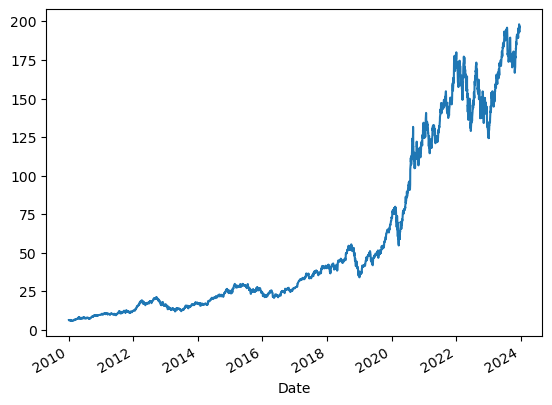

In [79]:
df['Adj Close'].plot()

## Feature engineering

In [80]:
# Moving Average Convergence Divergence (MACD): Identifies trend strength and potential turning points.
macd, signal, hist = MACD(df['Adj Close'], fastperiod=12, slowperiod=26, signalperiod=9)
df['MACD'] = macd
df['Signal'] = signal
df['MACD_Hist'] = hist

In [81]:
# Average True Range (ATR): Measures market volatility.
# Higher ATR values indicate higher market volatility, meaning prices are fluctuating more significantly.
# Lower ATR values indicate lower volatility, suggesting a calmer market with smaller price swings.
# You can use ATR to set stop-loss orders, manage risk, and identify potential trading opportunities based on volatility changes.

close_prices = df["Adj Close"]
high_prices = df["High"]
low_prices = df["Low"]

true_range = pd.Series(
    [max(hi - lo, abs(hi - close_prev), abs(lo - close_prev))
     for hi, lo, close_prev in zip(high_prices, low_prices, close_prices.shift(1))]
)

# Higher -> less sensitive to recent data change 
# Lower -> More sensitive to recent data cahange
# 14: Common window size, which can balance. 
window = 14
atr = true_range.rolling(window=window).mean()

atr_df = pd.DataFrame({'ATR': atr.values}, index=df.index)

# Merge the original DataFrame with the new ATR DataFrame
df = pd.merge(df, atr_df, left_index=True, right_index=True)


In [82]:
# Re-order the data frame

new_order = ["Open", "High", "Low", 'MACD', 'Signal',
       'MACD_Hist', "ATR", "Adj Close"]
df = df[new_order]
df.head()

,Open,High,Low,MACD,Signal,MACD_Hist,ATR,Adj Close
Date,,,,,,,,
2010-01-04,7.622500,7.660714,7.585000,NaN,NaN,NaN,NaN,6.478998
2010-01-05,7.664286,7.699643,7.616071,NaN,NaN,NaN,NaN,6.490200
2010-01-06,7.656429,7.686786,7.526786,NaN,NaN,NaN,NaN,6.386964
2010-01-07,7.562500,7.571429,7.466071,NaN,NaN,NaN,NaN,6.375157
2010-01-08,7.510714,7.571429,7.466429,NaN,NaN,NaN,NaN,6.417540


In [83]:
# Drop null values 
df.dropna(inplace=True)


In [84]:
# Select the features and the target 
target_y = df['Adj Close']
X_feat = df.iloc[:,0:7]

X_feat.head()

,Open,High,Low,MACD,Signal,MACD_Hist,ATR
Date,,,,,,,
2010-02-22,7.226429,7.232143,7.113929,-0.075296,-0.131832,0.056536,1.152492
2010-02-23,7.142857,7.190357,6.989643,-0.077542,-0.120974,0.043432,1.152968
2010-02-24,7.079643,7.194286,7.065714,-0.069724,-0.110724,0.041001,1.153536
2010-02-25,7.049286,7.245000,7.031786,-0.059568,-0.100493,0.040925,1.161898
2010-02-26,7.227857,7.327500,7.214286,-0.044604,-0.089315,0.044711,1.163774


In [85]:
# Scale the data using standard scaler 
# Standard scaler will scale between -1 and 1 

sc = StandardScaler() 
X_ft = sc.fit_transform(X_feat.values)
X_ft = pd.DataFrame(columns = X_feat.columns, 
                    data = X_ft, 
                    index = X_feat.index)

X_ft.shape

(3485, 7)

In [86]:
# Group features and target into 1 df 
stock_df = pd.concat([X_ft, df['Adj Close']], axis = 1)
stock_df.head()


,Open,High,Low,MACD,Signal,MACD_Hist,ATR,Adj Close
Date,,,,,,,,
2010-02-22,-0.959294,-0.960019,-0.960115,-0.288192,-0.343772,0.111521,-1.867284,6.067569
2010-02-23,-0.960806,-0.960766,-0.962389,-0.289648,-0.336263,0.083749,-1.866789,5.965849
2010-02-24,-0.961951,-0.960696,-0.960997,-0.284578,-0.329173,0.078595,-1.866199,6.074838
2010-02-25,-0.962500,-0.959789,-0.961618,-0.277993,-0.322097,0.078435,-1.857512,6.115403
2010-02-26,-0.959268,-0.958312,-0.958280,-0.268290,-0.314367,0.086458,-1.855563,6.194723


In [87]:
# Define a function to do split into training and testing 

def lstm_split(data, n_steps):
    X, y = [], []

    for i in range(len(data) - n_steps+1): 
        X.append(data[i:i + n_steps, :-1])
        y.append(data[i + n_steps -1, -1] )

    return np.array(X), np.array(y) 

In [88]:
# Generate train and test set
X1, y1 = lstm_split(stock_df.values, n_steps = 10) # Predict based on the data of past 2 days 

train_split = 0.8
split_idx = int(np.ceil(len(X1)*train_split))
date_index = stock_df.index

X_train, X_test = X1[:split_idx], X1[split_idx:]
y_train, y_test = y1[:split_idx], y1[split_idx:]
X_train_date, X_test_date = date_index[:split_idx], date_index[split_idx:]

print(X1.shape, X_train.shape, X_test.shape, y_test.shape)

(3476, 10, 7) (2781, 10, 7) (695, 10, 7) (695,)


## Build a simple LSTM model 

In [89]:
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu', return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')
lstm.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 32)                5120      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5153 (20.13 KB)
Trainable params: 5153 (20.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [90]:
# Add checkpoint to keep the best epoch 
from keras.callbacks import ModelCheckpoint
cp = ModelCheckpoint('model1/', save_best_only=True)

In [91]:
# Fit model to training data 

history = lstm.fit(X_train, y_train,
                   epochs=100, callbacks=[cp], batch_size=4,
                   verbose=2, shuffle=False)

Epoch 1/100


696/696 - 2s - loss: 821.5859 - 2s/epoch - 2ms/step
Epoch 2/100
696/696 - 1s - loss: 429.8520 - 1s/epoch - 2ms/step
Epoch 3/100
696/696 - 1s - loss: 190.4729 - 991ms/epoch - 1ms/step
Epoch 4/100
696/696 - 1s - loss: 115.2280 - 1s/epoch - 1ms/step
Epoch 5/100
696/696 - 1s - loss: 76.4244 - 1s/epoch - 2ms/step
Epoch 6/100
696/696 - 1s - loss: 43.3380 - 980ms/epoch - 1ms/step
Epoch 7/100
696/696 - 1s - loss: 31.5310 - 975ms/epoch - 1ms/step
Epoch 8/100
696/696 - 1s - loss: 21.7927 - 968ms/epoch - 1ms/step
Epoch 9/100
696/696 - 1s - loss: 20.1694 - 975ms/epoch - 1ms/step
Epoch 10/100
696/696 - 1s - loss: 17.2186 - 978ms/epoch - 1ms/step
Epoch 11/100
696/696 - 1s - loss: 15.3608 - 1s/epoch - 1ms/step
Epoch 12/100
696/696 - 1s - loss: 16.0621 - 1s/epoch - 1ms/step
Epoch 13/100
696/696 - 1s - loss: 31.3977 - 980ms/epoch - 1ms/step
Epoch 14/100
696/696 - 1s - loss: 35.5145 - 987ms/epoch - 1ms/step
Epoch 15/100
696/696 - 1s - loss: 10.4774 - 980ms/epoch - 1ms/step
Epoch 16/100
696/696 - 1s - lo

In [97]:
from tensorflow.keras.models import load_model

try:
    # Load the model from the specified directory
    model = load_model('model1/')
    print("Model loaded successfully.")
except Exception as e:
    print("Error loading the model:", e)


Error loading the model: SavedModel file does not exist at: model1//{saved_model.pbtxt|saved_model.pb}


## Performance evaluation 

In [92]:
# Evaluate the performance on a test set 

y_pred = model.predict(X_test)
y_pred.shape

22/22 [==============================] - 0s 651us/step


(695, 1)

In [93]:
print(y_pred.shape)
print(y_test.shape)

(695, 1)
(695,)


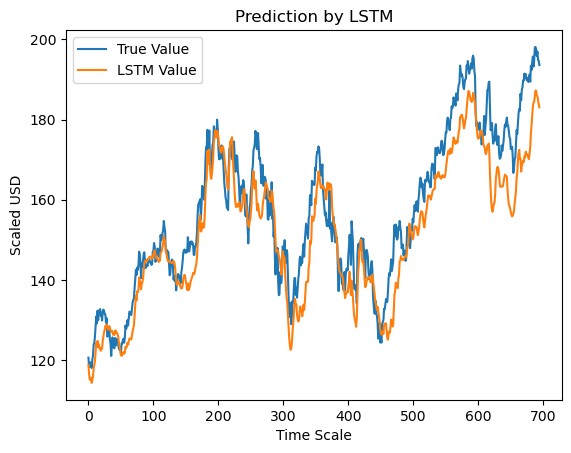

In [94]:
#Predicted vs True Adj Close Value – LSTM

plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Value')
plt.title('Prediction by LSTM')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

In [99]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred)
rsquared = r2_score(y_test, y_pred)
print("RMSE: ", rmse)
print("MAPE: ", mape)
print("R-Squared: ", rsquared)


RMSE:  8.121814815045086
MAPE:  0.041485288591780384
R-Squared:  0.8217658678317987


## Improved version of LSTM